In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# this makes sure cached files are readily available (for calling e.g. `gather_data_cached`)
!apt-get install git-lfs
!git lfs install

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Git LFS initialized.
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 693, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 693 (delta 25), reused 42 (delta 10), pack-reused 620 (from 1)
Receiving objects: 100% (693/693), 25.19 MiB | 13.88 MiB/s, done.
Resolving deltas: 100% (379/379), done.
Filtering content: 100% (32/32), 1.75 GiB | 67.62 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install ta
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0
FLASH_ATTN = False # set to true if using this
if FLASH_ATTN:
  !pip install flash-attn==2.6.3 # optional but recommended by the repo

In [3]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime

# Custom Imports
from models.statistical_models import create_dataset, default_normalize, rmse_metric, acc_metric, kalman_filter_average, kalman_filter_regression, kalman_filter_regression_multivariate
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, save_pairs_data_filtered

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# 1. A function for converting a longer timeperiod into a smaller one

In [ ]:
# Longest time period we have is
startDateStr = '2007-01-01'
endDateStr = '2024-12-31'

# gather the cached data and pairs_filter_data for it
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
# data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
# data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

# scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2) # note, from all 820 pairs, only 95 are returned, because we filter out all pairs that have a cointegration score <0.05
# pairs_data = {key:value[1]  for (key, value) in pairs.items()}
# pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
# pairs_data_filtered = filter_pairs_data(pairs_data)

startDateStrTrunc = '2008-10-01'
endDateStrTrunc = '2018-10-02'

def truncate_data(data, startDateStrTrunc, endDateStrTrunc):
  data_close_truncated = data['close'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1] # reason for .iloc[:-1] -> the gather_data and gather_data_cached functions do not include endDateStrTrunc in the data, but using .loc slicing does include it. Therefore we remove one.
  data_open_truncated = data['open'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  data_high_truncated = data['high'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  data_low_truncated = data['low'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  data_vol_truncated = data['vol'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  data_yfinance_formatted_truncated = data['yfinance_formatted'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  return {
      'close': data_close_truncated,
      'open': data_open_truncated,
      'high': data_high_truncated,
      'low': data_low_truncated,
      'vol': data_vol_truncated,
      'yfinance_formatted': data_yfinance_formatted_truncated
  }


# 2. Checking similarity: see whether different timeperiods even contain the same data

In [ ]:
startDateStrTrunc = '2008-10-01'
endDateStrTrunc = '2018-10-02'
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()

## 1. gather the original way
data_original_way = gather_data_cached(startDateStrTrunc, endDateStrTrunc, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

## 2. gather the new way
data_long_version = gather_data_cached('2007-01-01', '2024-12-31', instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_new_way = truncate_data(data_long_version, startDateStrTrunc, endDateStrTrunc)

## 3. see whether there's a difference
data_new_way['yfinance_formatted'].shape, data_original_way['yfinance_formatted'].shape # ((2519, 4662), (2518, 4662))

data_new_way['yfinance_formatted'] # first date is 2008-10-01, last date is 2018-10-02
data_original_way['yfinance_formatted'] # first date is 2008-10-01, last date is 2018-10-01 -> in the original way, the endDateStr is NOT inclusive. So we must change the truncate func to not include the last date. Therefore we added .iloc[:-1]
# perhaps the difference is gone when we filter
data_close_filtered_1_original_way, data_open_filtered_1_original_way, data_high_filtered_1_original_way, data_low_filtered_1_original_way, data_vol_filtered_1_original_way, data_original_format_filtered_1_original_way = step_1_filter_remove_nans(data_original_way['close'], data_original_way['open'], data_original_way['high'], data_original_way['low'], data_original_way['vol'], data_original_way)
data_close_filtered_2_original_way, data_open_filtered_2_original_way, data_high_filtered_2_original_way, data_low_filtered_2_original_way, data_vol_filtered_2_original_way, data_original_format_filtered_2_original_way = step_2_filter_liquidity(data_close_filtered_1_original_way, data_open_filtered_1_original_way, data_high_filtered_1_original_way, data_low_filtered_1_original_way, data_vol_filtered_1_original_way, data_original_format_filtered_1_original_way)

data_close_filtered_1_new_way, data_open_filtered_1_new_way, data_high_filtered_1_new_way, data_low_filtered_1_new_way, data_vol_filtered_1_new_way, data_original_format_filtered_1_new_way = step_1_filter_remove_nans(data_new_way['close'], data_new_way['open'], data_new_way['high'], data_new_way['low'], data_new_way['vol'], data_new_way)
data_close_filtered_2_new_way, data_open_filtered_2_new_way, data_high_filtered_2_new_way, data_low_filtered_2_new_way, data_vol_filtered_2_new_way, data_original_format_filtered_2_new_way = step_2_filter_liquidity(data_close_filtered_1_new_way, data_open_filtered_1_new_way, data_high_filtered_1_new_way, data_low_filtered_1_new_way, data_vol_filtered_1_new_way, data_original_format_filtered_1_new_way)

data_original_format_filtered_2_new_way.shape, data_original_format_filtered_2_original_way.shape # ((2518, 246), (2518, 246))

data_new_way['yfinance_formatted'].shape

# 2.1 New gather_data_cached function that uses truncation


In [8]:
import pickle
def truncate_data(data, startDateStrTrunc, endDateStrTrunc):
  data_close_truncated = data['close'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1] # reason for .iloc[:-1] -> the gather_data and gather_data_cached functions do not include endDateStrTrunc in the data, but using .loc slicing does include it. Therefore we remove one.
  data_open_truncated = data['open'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  data_high_truncated = data['high'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  data_low_truncated = data['low'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  data_vol_truncated = data['vol'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1]
  data_yfinance_formatted_truncated = data['yfinance_formatted'].loc[startDateStrTrunc:endDateStrTrunc].iloc[:-1] # TODO: using .iloc is a bit wonky (only on this line, previous lines give exactly as expected) - it does give the correct shape for yfinance_formatted, but is not equal to the original function.
  return {
      'close': data_close_truncated,
      'open': data_open_truncated,
      'high': data_high_truncated,
      'low': data_low_truncated,
      'vol': data_vol_truncated,
      'yfinance_formatted': data_yfinance_formatted_truncated
  }

def gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIds, cache_dir='.'):
    """
    Load the data from a cached file, given arguments matching gather_data.
    """
    # hardcoded to be the longest period that we have currently downloaded
    startDateStrEarliest = '2007-01-01'
    endDateStrLatest = '2024-12-31'
    filename = _get_filename(startDateStrEarliest, endDateStrLatest, instrumentIds)
    filepath = os.path.join(cache_dir, filename)
    with open(filepath, 'rb') as f:
        data = pickle.load(f)

    # now, truncate to be the shorter time period
    data_truncated = truncate_data(data, startDateStr, endDateStr)
    return data_truncated



# 3. Creating new plots of the form shown below using many different time periods
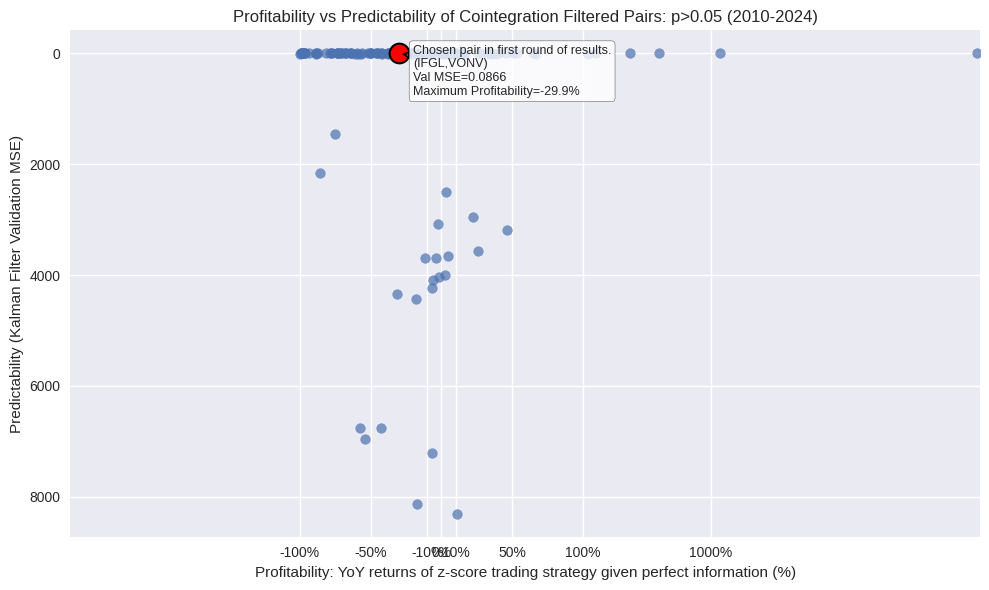

In [6]:
# plotting
import matplotlib.pyplot as plt

from datetime import datetime
def _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest, verbose=False):
  """
  For certain periods, we want a specific testing period, and must therefore calculate the train/dev split based on that.
  """
  # convert all 4 dates to datetime
  startDateStr = datetime.strptime(startDateStr, '%Y-%m-%d')
  endDateStr = datetime.strptime(endDateStr, '%Y-%m-%d')
  startDateStrTest = datetime.strptime(startDateStrTest, '%Y-%m-%d')
  endDateStrTest = datetime.strptime(endDateStrTest, '%Y-%m-%d')

  total_days = (endDateStr - startDateStr).days
  test_days = (endDateStrTest - startDateStrTest).days
  train_days = total_days - 2 * test_days

  train_frac = train_days / total_days
  test_frac = test_days / total_days
  dev_frac = test_frac

  if verbose:
    print(f"train_frac: {train_frac}")
    print(f"dev_frac: {dev_frac}")
    print(f"test_frac: {test_frac}")

  return train_frac, dev_frac


def plot_predictability_profitability(startDateStr, endDateStr, train_frac_current, dev_frac_current):
  global cached_results
  period_key = f"{startDateStr}_{endDateStr}"

  start_year = startDateStr.split("-")[0]
  amount_of_plots_gathered_current_year = sum([start_year in key for key in cached_results.keys()])
  if amount_of_plots_gathered_current_year >= 9:
    print("creating large figure with 9 subplots")
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    axs = axs.flatten()

    subplot_index = 0
    for period_key, current_results in cached_results.items():
      start_year_current = period_key.split("-")[0]
      if start_year_current != start_year:
        continue
      print(f"creating figure for period: {period_key}")

      pair_names = [r[0] for r in current_results]
      profitability = [r[1] * 100 for r in current_results]  # gt_yoy
      predictability = [r[2] for r in current_results]  # val_mse

      ax = axs[subplot_index]
      ax.scatter(profitability, predictability, alpha=0.7)
      ax.set_xlabel("Profitability (%)")
      ax.set_ylabel("Predictability (MSE)")
      period_title = period_key.replace("-", ".")
      period_title = period_title.replace("_", "-")
      ax.set_title(f"{period_title}")

      # Highlight lowest MSE pair
      lowest_mse_pair = min(current_results, key=lambda x: x[2])
      lowest_pair_name = lowest_mse_pair[0]
      lowest_pair_profitability = lowest_mse_pair[1] * 100
      lowest_pair_predictability = lowest_mse_pair[2]

      ax.scatter([lowest_pair_profitability], [lowest_pair_predictability],
                  color='red', s=100, edgecolors='black', linewidths=1.5)
      ax.annotate(f'{lowest_pair_name}\nMSE={lowest_pair_predictability:.2f}\nProfit={lowest_pair_profitability:.1f}%',
                  (lowest_pair_profitability, lowest_pair_predictability),
                  textcoords="offset points", xytext=(10, -25), ha='left',
                  fontsize=8, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8),
                  arrowprops=dict(arrowstyle="->", lw=1))

      ax.invert_yaxis()
      ax.set_xscale('symlog', linthresh=100)
      ax.set_yscale('log')
      ax.set_yticks([0.01, 0.1, 0.2, 0.5, 1, 10])
      ax.set_yticklabels(['0.01', '0.1', '0.2', '0.5', '1', '10'])
      ax.set_xticks([-100, -50, 0, 50, 100, 1000])
      ax.set_xticklabels(['-100%', '-50%', '0%', '50%', '100%', '1000%'])
      ax.grid(True)

      subplot_index += 1
      if subplot_index >= 9:
          plt.tight_layout()
          break
    return True

  if period_key in cached_results:
    print(f"Loaded cached results for period: {period_key}")
    results = cached_results[period_key]
  else:
      print(f"Computing results for period: {period_key}")
      instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
      data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

      data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
      data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

      pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
      if not pairs_data_filtered:
        scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
        pairs_data = {key:value[1]  for (key, value) in pairs.items()}
        pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
        pairs_data_filtered = filter_pairs_data(pairs_data)
        # extra; save it if it wasn't already
        save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
      results = []
      for i in tqdm(range(len(pairs_data_filtered)), desc = f"Gathering val MSE and returns ({period_key}).."):
          ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
          pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
          pair_tup_str = f"({ticker_a},{ticker_b})"
          output = execute_kalman_workflow(pair_data=pairs_timeseries_df, verbose=False, pair_tup_str=pair_tup_str, add_technical_indicators=True, train_frac=train_frac_current, dev_frac=dev_frac_current)
          results.append((pair_tup_str, output['gt_yoy'], output['val_mse']))

      # Cache results
      cached_results[period_key] = results

  pair_names = [r[0] for r in results]
  profitability = [r[1] * 100 for r in results]  # gt_yoy
  predictability = [r[2] for r in results]  # val_mse
  plt.figure(figsize=(10, 6))
  plt.scatter(profitability, predictability, alpha=0.7)
  plt.xlabel("Profitability: YoY returns of z-score trading strategy given perfect information (%)")

  most_negative_profitability = min(profitability) # -98, because we can't lose more than 100% of course!
  lowest_mse_pair = min(results, key=lambda x: x[2])
  print("lowest_mse_pair", lowest_mse_pair)
  lowest_pair_name = lowest_mse_pair[0]
  lowest_pair_profitability = lowest_mse_pair[1] * 100
  lowest_pair_predictability = lowest_mse_pair[2]

  # Add big, special marker for lowest MSE pair
  plt.scatter([lowest_pair_profitability], [lowest_pair_predictability],
              color='red', s=200, edgecolors='black', linewidths=1.5)

  # Annotate the lowest MSE pair
  plt.annotate(f'Chosen pair in first round of results.\n{lowest_pair_name}\nVal MSE={lowest_pair_predictability:.4f}\nMaximum Profitability={lowest_pair_profitability:.1f}%',
              (lowest_pair_profitability, lowest_pair_predictability),
              textcoords="offset points", xytext=(10, -30), ha='left',
              fontsize=9, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.8),
              arrowprops=dict(arrowstyle="->", lw=1))

  plt.ylabel("Predictability (Kalman Filter Validation MSE)")
  startYear = startDateStr.split("-")[0]
  endYear = endDateStr.split("-")[0]
  plt.title(f"Profitability vs Predictability of Cointegration Filtered Pairs: p>0.05 ({startYear}-{endYear})")
  plt.gca().invert_yaxis() # invert y-axis, because lower MSE is better
  plt.xscale('symlog', linthresh=100)  # use log for outliers, because some percentages go to 2000%, but most are between-50% and 50%
  plt.xticks([-100, -50, -10, 0, 10, 50, 100, 1000], ['-100%', '-50%', '-10%', '0%', '10%', '50%', '100%', '1000%'])

  # optional: annotate all pairs
  # for i, name in enumerate(pair_names):
  #     plt.annotate(name, (profitability[i], predictability[i]), fontsize=8, alpha=0.6)

  plt.grid(True)
  plt.tight_layout()
  plt.show()


start_year = 2008
end_years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
for end_year in end_years:
  startDateStrCurrent = f'{start_year}-01-01'
  endDateStrCurrent = f'{end_year}-12-31'
  startDateStrTestCurrent = f'{end_year}-01-01'
  endDateStrTestCurrent = f'{end_year}-12-31'
  train_frac_current, dev_frac_current = _get_train_dev_frac(startDateStrCurrent, endDateStrCurrent, startDateStrTestCurrent, endDateStrTestCurrent)

  if plot_predictability_profitability(startDateStrCurrent, endDateStrCurrent, train_frac_current, dev_frac_current):
    break

NameError: name 'cached_results' is not defined

In [4]:
def get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back):
  burn_in = 20

  pairs_timeseries_df_burned_in = pairs_timeseries_df.iloc[burn_in:].copy()

  total_len = len(pairs_timeseries_df_burned_in)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train = pairs_timeseries_df_burned_in.iloc[:train_size]
  dev   = pairs_timeseries_df_burned_in.iloc[train_size:train_size + dev_size]
  test  = pairs_timeseries_df_burned_in.iloc[train_size + dev_size:]


  index_shortened = test.index[:len(test['Spread_Close'].values[look_back:])] # problem: test['S1_close'].iloc[look_back:] and testY_untr are the same.. So we should rather be using test
  spread_gt_series = pd.Series(test['Spread_Close'].values[look_back:], index=index_shortened)
  gt_returns_test = trade(
      S1 = test['S1_close'].iloc[look_back:],
      S2 = test['S2_close'].iloc[look_back:],
      spread = spread_gt_series,
      window_long = 30,
      window_short = 5,
      position_threshold = 3,
      clearing_threshold = 0.4
  )
  gt_yoy_test = ((gt_returns_test[-1] / gt_returns_test[0])**(365 / len(gt_returns_test)) - 1)

  index_shortened = dev.index[:len(dev['Spread_Close'].values[look_back:])]
  spread_gt_series = pd.Series(dev['Spread_Close'].values[look_back:], index=index_shortened)
  gt_returns_dev = trade(
      S1 = dev['S1_close'].iloc[look_back:],
      S2 = dev['S2_close'].iloc[look_back:],
      spread = spread_gt_series,
      window_long = 30,
      window_short = 5,
      position_threshold = 3,
      clearing_threshold = 0.4
  )
  gt_yoy_dev = ((gt_returns_dev[-1] / gt_returns_dev[0])**(365 / len(gt_returns_dev)) - 1)
  return {
      "gt_yoy_test": gt_yoy_test,
      "gt_yoy_dev": gt_yoy_dev
  }

Gathering val MSE and returns..:   0%|          | 0/66 [00:00<?, ?it/s]

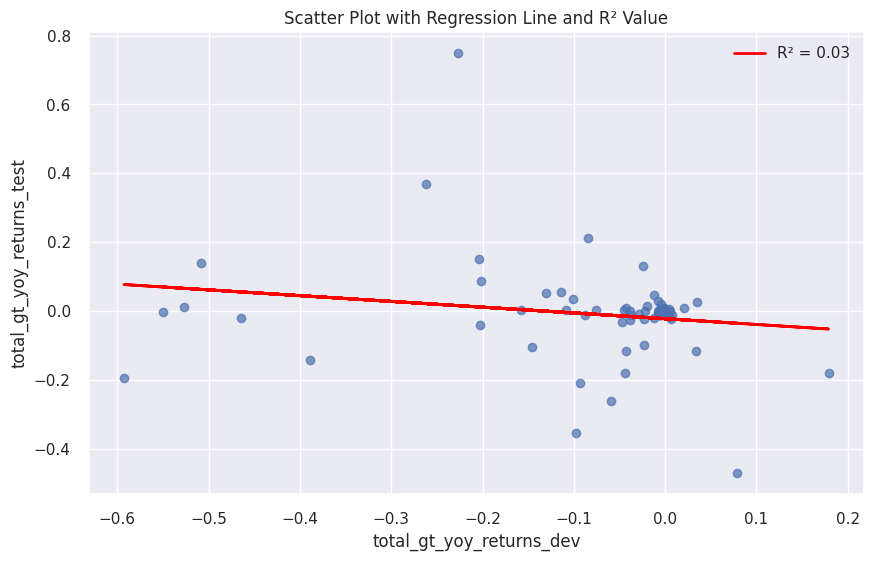

Pearson r: -0.1717
R-squared: 0.0295
P-value: 1.6795e-01


Gathering val MSE and returns..:   0%|          | 0/88 [00:00<?, ?it/s]

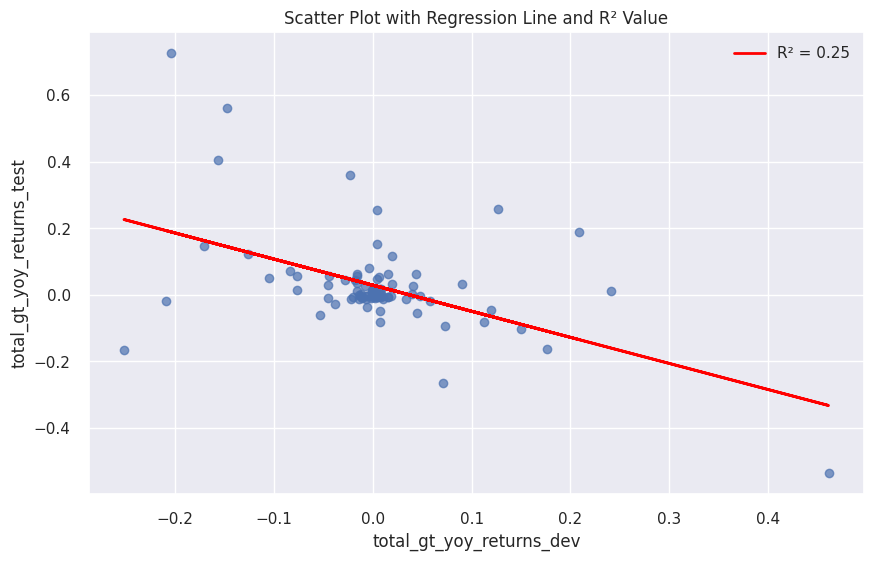

Pearson r: -0.4961
R-squared: 0.2461
P-value: 8.8754e-07


Gathering val MSE and returns..:   0%|          | 0/77 [00:00<?, ?it/s]

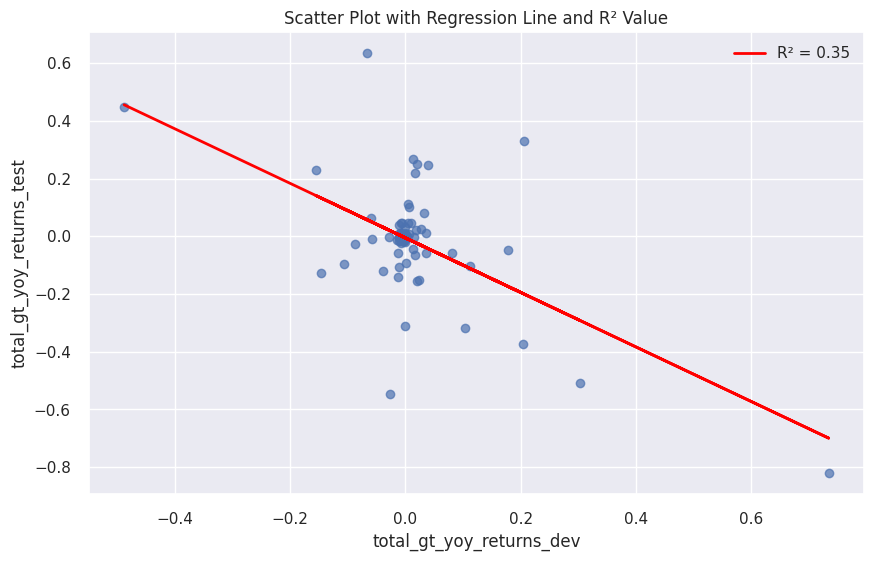

Pearson r: -0.5954
R-squared: 0.3545
P-value: 1.1188e-08


Gathering val MSE and returns..:   0%|          | 0/80 [00:00<?, ?it/s]

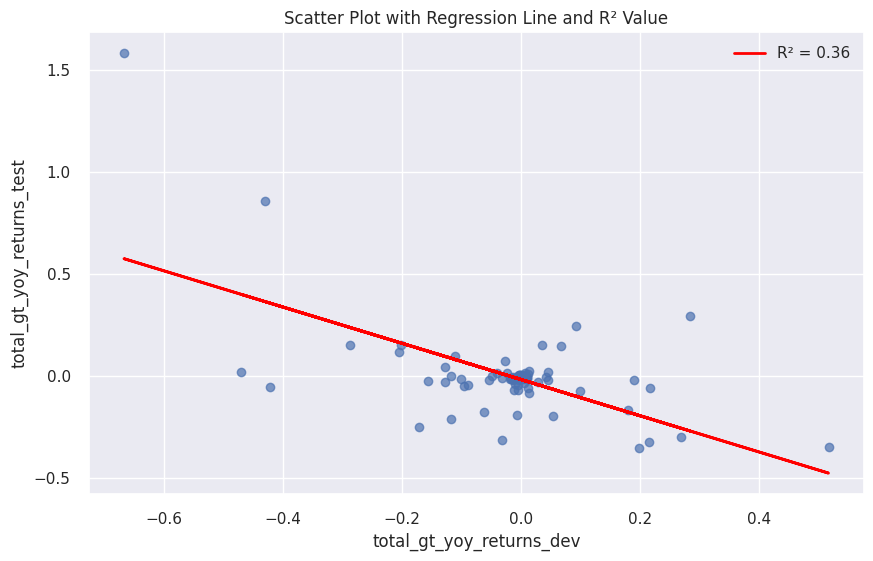

Pearson r: -0.6001
R-squared: 0.3601
P-value: 4.0239e-09


Gathering val MSE and returns..:   0%|          | 0/78 [00:00<?, ?it/s]

<ipython-input-4-36a72f697718>:27: RuntimeWarning: invalid value encountered in scalar power
  gt_yoy_test = ((gt_returns_test[-1] / gt_returns_test[0])**(365 / len(gt_returns_test)) - 1)


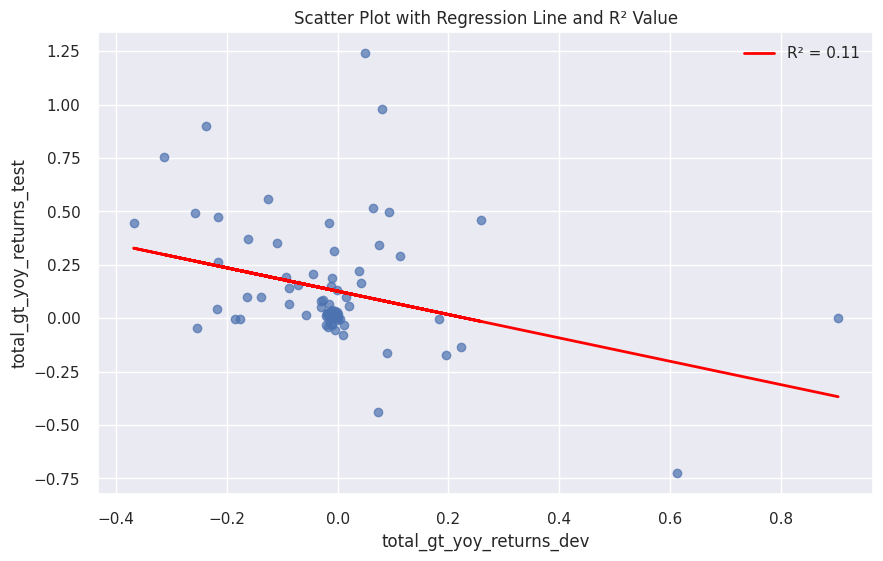

Pearson r: -0.3260
R-squared: 0.1062
P-value: 3.5878e-03


Gathering val MSE and returns..:   0%|          | 0/91 [00:00<?, ?it/s]

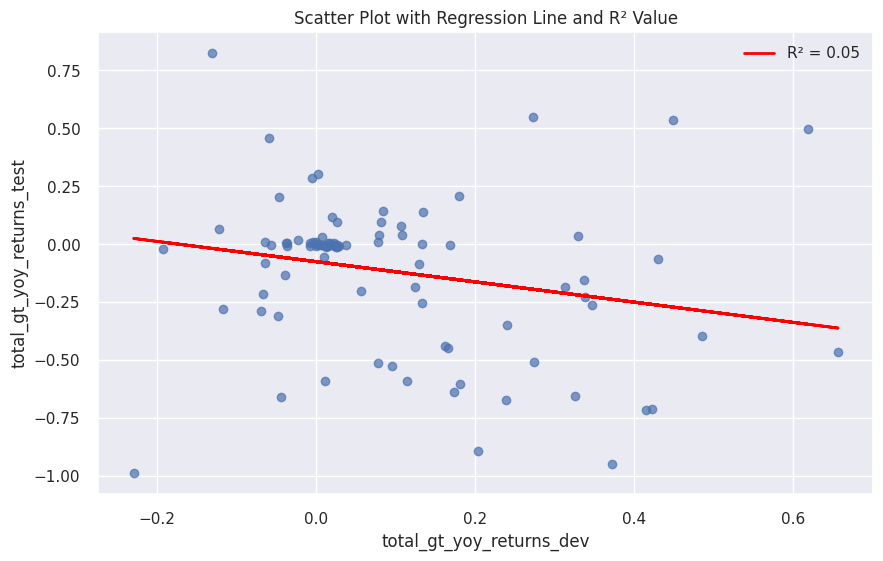

Pearson r: -0.2271
R-squared: 0.0516
P-value: 3.0388e-02


Gathering val MSE and returns..:   0%|          | 0/86 [00:00<?, ?it/s]

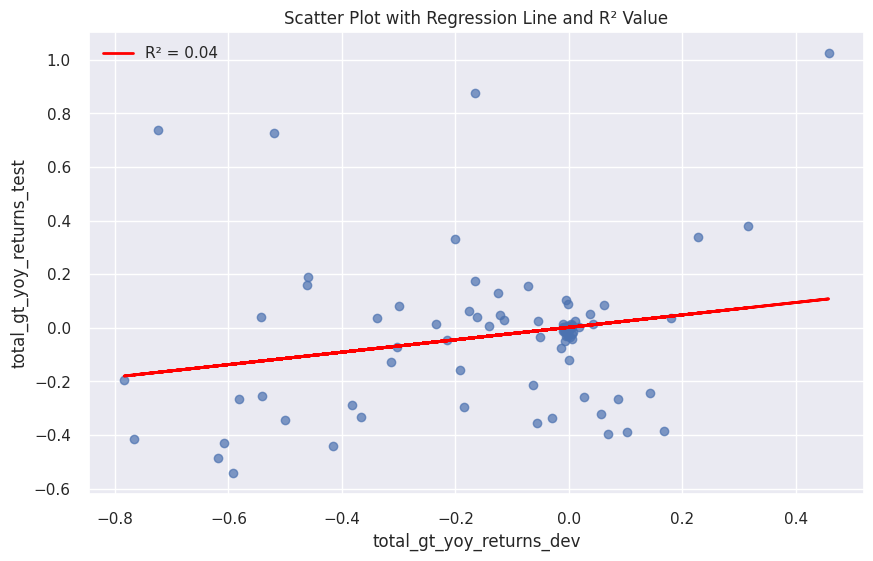

Pearson r: 0.2108
R-squared: 0.0444
P-value: 5.1358e-02


Gathering val MSE and returns..:   0%|          | 0/102 [00:00<?, ?it/s]

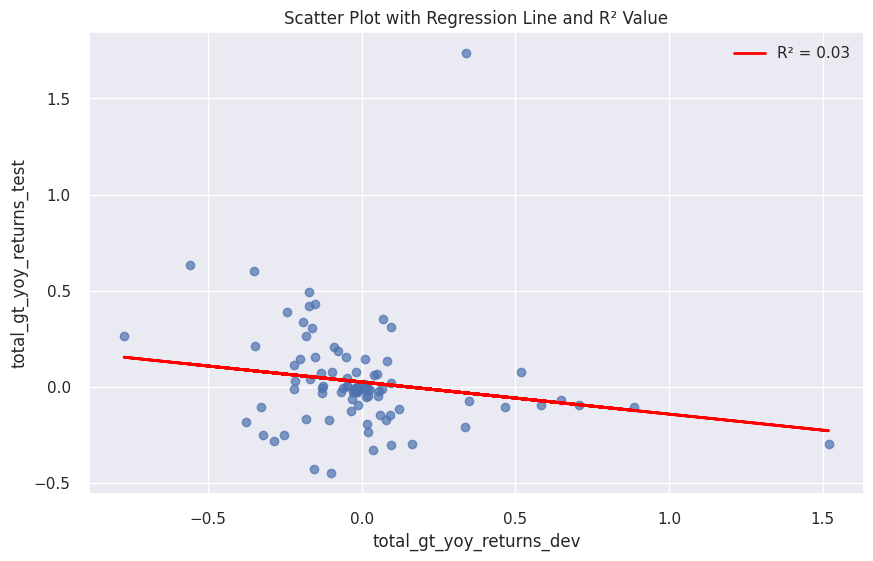

Pearson r: -0.1780
R-squared: 0.0317
P-value: 7.3433e-02


Gathering val MSE and returns..:   0%|          | 0/103 [00:00<?, ?it/s]

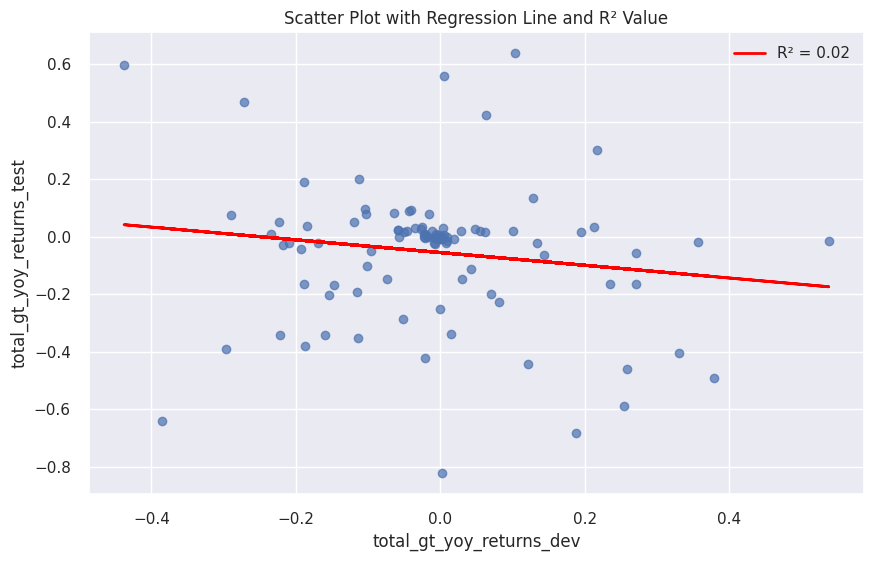

Pearson r: -0.1481
R-squared: 0.0219
P-value: 1.3534e-01


In [17]:
# Let's see how well validation YoY return predicts test YoY return.
total_gt_yoy_returns_dev = []
total_gt_yoy_returns_test = []

start_year = 2008
end_years = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
for end_year in end_years:
  total_gt_yoy_returns_dev = []
  total_gt_yoy_returns_test = []
  startDateStrCurrent = f'{start_year}-01-01'
  endDateStrCurrent = f'{end_year}-12-31'
  startDateStrTestCurrent = f'{end_year}-01-01'
  endDateStrTestCurrent = f'{end_year}-12-31'
  train_frac_current, dev_frac_current = _get_train_dev_frac(startDateStrCurrent, endDateStrCurrent, startDateStrTestCurrent, endDateStrTestCurrent)

  instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
  data = gather_data_cached_using_truncate(startDateStrCurrent, endDateStrCurrent, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

  data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
  data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

  pairs_data_filtered = gather_pairs_data_cached(startDateStrCurrent, endDateStrCurrent, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  if not pairs_data_filtered:
    scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
    pairs_data = {key:value[1]  for (key, value) in pairs.items()}
    pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
    pairs_data_filtered = filter_pairs_data(pairs_data)
    # extra; save it if it wasn't already
    save_pairs_data_filtered(pairs_data_filtered, startDateStrCurrent, endDateStrCurrent, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
  for i in tqdm(range(len(pairs_data_filtered)), desc = f"Gathering val MSE and returns.."):
      ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
      pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
      output = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac=dev_frac_current, train_frac=train_frac_current, look_back=1)
      total_gt_yoy_returns_dev.append(output['gt_yoy_dev'])
      total_gt_yoy_returns_test.append(output['gt_yoy_test'])
  # Assuming total_gt_yoy_returns_dev and total_gt_yoy_returns_test are 1D numpy arrays or lists
  x = np.array(total_gt_yoy_returns_dev).reshape(-1, 1)
  y = np.array(total_gt_yoy_returns_test)

  # fill x and y with 0 if nan
  x = np.nan_to_num(x)
  y = np.nan_to_num(y)

  # Compute Pearson correlation
  r, p_value = pearsonr(x.flatten(), y)
  r_squared = r**2

  # Fit a linear regression model
  model = LinearRegression()
  model.fit(x, y)
  y_pred = model.predict(x)

  # Plot the scatter and regression line
  plt.figure(figsize=(10, 6))
  sns.set(style="darkgrid")
  plt.scatter(x, y, alpha=0.7)
  plt.plot(x, y_pred, color='red', linewidth=2, label=f'R² = {r_squared:.2f}')
  plt.xlabel('total_gt_yoy_returns_dev')
  plt.ylabel('total_gt_yoy_returns_test')
  plt.title('Scatter Plot with Regression Line and R² Value')
  plt.legend()
  plt.show()

  # Optional: print the statistics
  print(f"Pearson r: {r:.4f}")
  print(f"R-squared: {r_squared:.4f}")
  print(f"P-value: {p_value:.4e}")

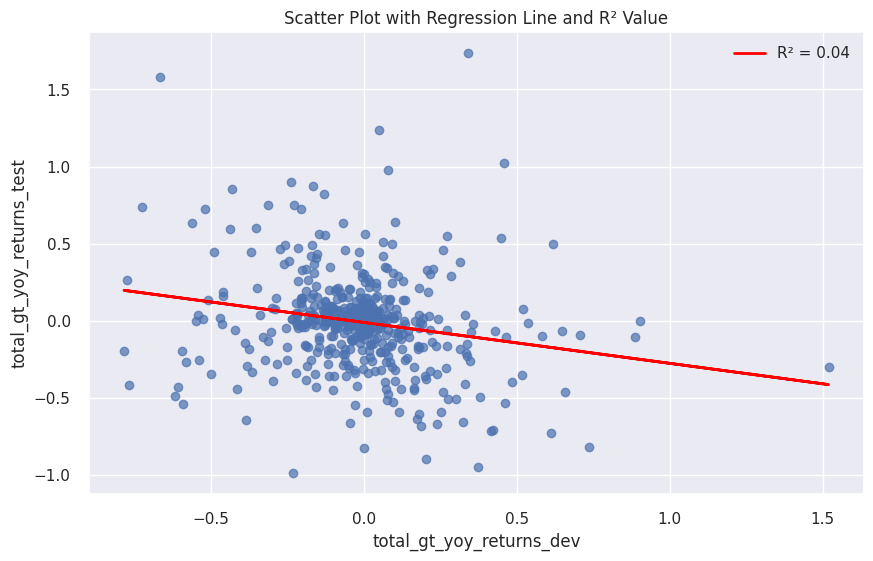

Pearson r: -0.2029
R-squared: 0.0412
P-value: 1.3057e-08


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Assuming total_gt_yoy_returns_dev and total_gt_yoy_returns_test are 1D numpy arrays or lists
x = np.array(total_gt_yoy_returns_dev).reshape(-1, 1)
y = np.array(total_gt_yoy_returns_test)

# fill x and y with 0 if nan
x = np.nan_to_num(x)
y = np.nan_to_num(y)

# Compute Pearson correlation
r, p_value = pearsonr(x.flatten(), y)
r_squared = r**2

# Fit a linear regression model
model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)

# Plot the scatter and regression line
plt.figure(figsize=(10, 6))
sns.set(style="darkgrid")
plt.scatter(x, y, alpha=0.7)
plt.plot(x, y_pred, color='red', linewidth=2, label=f'R² = {r_squared:.2f}')
plt.xlabel('total_gt_yoy_returns_dev')
plt.ylabel('total_gt_yoy_returns_test')
plt.title('Scatter Plot with Regression Line and R² Value')
plt.legend()
plt.show()

# Optional: print the statistics
print(f"Pearson r: {r:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"P-value: {p_value:.4e}")
